<a href="https://colab.research.google.com/github/cassia-crypto/E-Commerce-Product-Recommendation/blob/main/E_Commerce_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()



Saving E-commerce.csv to E-commerce.csv


In [3]:
import pandas as pd
df = pd.read_csv('/content/E-commerce.csv')  # Replace with actual file name
df.head()


,Customer ID,Age,Gender,Location,Annual Income,Purchase History,Browsing History,Product Reviews,Time on Site
0,1001,25,Female,City D,45000,"[{""Date"": ""2022-03-05"", ""Category"": ""Clothing""...","[{""Timestamp"": ""2022-03-10T14:30:00Z""}, {""Time...","Great pair of jeans, very comfortable. Rating:...",32.50
1,1001,28,Female,City D,52000,"[{""Product Category"": ""Clothing"", ""Purchase Da...","[{""Product Category"": ""Home & Garden"", ""Timest...",Great customer service!,123.45
2,1001,28,Female,City D,65000,"[{""Product Category"": ""Electronics"", ""Purchase...","[{""Product Category"": ""Clothing"", ""Timestamp"":...",Great electronics. The sound quality is excell...,125.60
3,1001,45,Female,City D,70000,"{'Purchase Date': '2022-08-15', 'Product Categ...",{'Timestamp': '2022-09-03 14:30:00'},"{""Product 1"": {""Rating"": 4, ""Review"": ""Great e...",327.60
4,1002,34,Male,City E,45000,"{'Purchase Date': '2022-07-25', 'Product Categ...",{'Timestamp': '2022-08-10 17:15:00'},"{""Product 1"": {""Rating"": 3, ""Review"": ""Good pr...",214.90


In [4]:
import ast

def safe_parse(x):
    if isinstance(x, str):
        x = x.strip()
        if x.startswith("{") or x.startswith("["):
            try:
                return ast.literal_eval(x)
            except (ValueError, SyntaxError):
                return x  # leave as-is if it's not valid
    return x

# Now apply to each column safely
json_columns = ['Purchase History', 'Browsing History', 'Product Reviews']
for col in json_columns:
    df[col] = df[col].apply(safe_parse)


In [5]:
for col in json_columns:
    print(f"\nColumn: {col}")
    print(df[col].apply(type).value_counts())



Column: Purchase History
Purchase History
<class 'tuple'>    33
<class 'list'>     16
<class 'dict'>      1
Name: count, dtype: int64

Column: Browsing History
Browsing History
<class 'dict'>    34
<class 'list'>    16
Name: count, dtype: int64

Column: Product Reviews
Product Reviews
<class 'str'>     29
<class 'dict'>    21
Name: count, dtype: int64


In [6]:
# Fix Purchase History
purchase_records = []

for idx, row in df.iterrows():
    customer_id = row['Customer ID']
    data = row['Purchase History']

    if isinstance(data, tuple):  # convert tuple to list
        data = list(data)

    if isinstance(data, list):
        for entry in data:
            if isinstance(entry, dict):
                purchase_records.append({
                    'Customer ID': customer_id,
                    'Purchase Date': entry.get('Purchase Date') or entry.get('Date'),
                    'Product Category': entry.get('Product Category') or entry.get('Category')
                })
    elif isinstance(data, dict):
        purchase_records.append({
            'Customer ID': customer_id,
            'Purchase Date': data.get('Purchase Date'),
            'Product Category': data.get('Product Category')
        })

purchase_df = pd.DataFrame(purchase_records)


In [7]:
# Fix Browsing History
browsing_records = []

for idx, row in df.iterrows():
    customer_id = row['Customer ID']
    data = row['Browsing History']

    if isinstance(data, dict):
        data = [data]  # wrap single dict in a list

    if isinstance(data, list):
        for entry in data:
            if isinstance(entry, dict):
                browsing_records.append({
                    'Customer ID': customer_id,
                    'Browsing Timestamp': entry.get('Timestamp'),
                    'Browsed Category': entry.get('Product Category') or entry.get('Category')
                })

browsing_df = pd.DataFrame(browsing_records)


In [8]:
# Fix Product Reviews — extract numeric rating
import re

def extract_rating_from_text_or_dict(review):
    if isinstance(review, dict):
        for prod, val in review.items():
            return val.get('Rating')  # e.g., {"Product 1": {"Rating": 4, ...}}
    elif isinstance(review, str):
        match = re.search(r'Rating[:=]?\s*(\d+)', review)
        if match:
            return int(match.group(1))
    return None

df['Review Rating'] = df['Product Reviews'].apply(extract_rating_from_text_or_dict)


AttributeError: 'str' object has no attribute 'get'

In [9]:
# Updated extract function
def extract_rating_from_text_or_dict(review):
    if isinstance(review, dict):
        # If review is a dict, extract Rating from it
        for prod, val in review.items():
            return val.get('Rating')  # Example: {"Product 1": {"Rating": 4}}
    elif isinstance(review, str):
        # If review is a string, look for a rating in the text
        match = re.search(r'Rating[:=]?\s*(\d+)', review)
        if match:
            return int(match.group(1))
    return None  # Return None if no rating found

# Apply the function to the 'Product Reviews' column
df['Review Rating'] = df['Product Reviews'].apply(extract_rating_from_text_or_dict)


AttributeError: 'str' object has no attribute 'get'

In [10]:
def extract_rating_from_text_or_dict(review):
    if isinstance(review, dict):  # If it's a dict, get the Rating from it
        # We assume there’s only one product in each review dict
        for prod, val in review.items():
            return val.get('Rating', None)  # Extract 'Rating' key
    elif isinstance(review, str):  # If it's a string, try to extract the rating from it
        # Search for patterns like 'Rating: 4' or 'Rating = 4'
        match = re.search(r'Rating[:=]?\s*(\d+)', review)
        if match:
            return int(match.group(1))
    return None  # If no rating is found

# Apply this function to the 'Product Reviews' column
df['Review Rating'] = df['Product Reviews'].apply(extract_rating_from_text_or_dict)


AttributeError: 'str' object has no attribute 'get'

In [12]:
def extract_rating_from_text_or_dict(review):
    if isinstance(review, dict):
        # If the review is a dictionary, try to extract the rating
        for prod, val in review.items():
            if isinstance(val, dict):  # Check if 'val' is a dictionary
                return val.get('Rating', None)
            elif isinstance(val, str):  # If it's a string, try to extract rating from it
                match = re.search(r'Rating[:=]?\s*(\d+)', val)
                if match:
                    return int(match.group(1))
    elif isinstance(review, str):
        # If the review is a string, extract rating directly from the text
        match = re.search(r'Rating[:=]?\s*(\d+)', review)
        if match:
            return int(match.group(1))

    return None  # If no rating is found

# Apply this function to the 'Product Reviews' column
df['Review Rating'] = df['Product Reviews'].apply(extract_rating_from_text_or_dict)


In [13]:
# Check the first few rows to see how it's working
print(df[['Customer ID', 'Product Reviews', 'Review Rating']].head())


   Customer ID                                    Product Reviews  \
0         1001  Great pair of jeans, very comfortable. Rating:...   
1         1001                            Great customer service!   
2         1001  Great electronics. The sound quality is excell...   
3         1001  {'Product 1': {'Rating': 4, 'Review': 'Great e...   
4         1002  {'Product 1': {'Rating': 3, 'Review': 'Good pr...   

   Review Rating  
0            4.0  
1            NaN  
2            NaN  
3            4.0  
4            3.0  


In [14]:
# Calculate the mean of the 'Review Rating' column, ignoring NaNs
mean_rating = df['Review Rating'].mean()

# Fill NaN values with the calculated mean rating
df['Review Rating'].fillna(mean_rating, inplace=True)

# Check the updated dataframe
print(df[['Customer ID', 'Product Reviews', 'Review Rating']].head())


   Customer ID                                    Product Reviews  \
0         1001  Great pair of jeans, very comfortable. Rating:...   
1         1001                            Great customer service!   
2         1001  Great electronics. The sound quality is excell...   
3         1001  {'Product 1': {'Rating': 4, 'Review': 'Great e...   
4         1002  {'Product 1': {'Rating': 3, 'Review': 'Good pr...   

   Review Rating  
0            4.0  
1            3.9  
2            3.9  
3            4.0  
4            3.0  


<ipython-input-14-240a2a132e13>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Review Rating'].fillna(mean_rating, inplace=True)


In [15]:
# Calculate the mean of the 'Review Rating' column, ignoring NaNs
mean_rating = df['Review Rating'].mean()

# Fill NaN values with the calculated mean rating
df['Review Rating'] = df['Review Rating'].fillna(mean_rating)

# Check the updated dataframe
print(df[['Customer ID', 'Product Reviews', 'Review Rating']].head())


   Customer ID                                    Product Reviews  \
0         1001  Great pair of jeans, very comfortable. Rating:...   
1         1001                            Great customer service!   
2         1001  Great electronics. The sound quality is excell...   
3         1001  {'Product 1': {'Rating': 4, 'Review': 'Great e...   
4         1002  {'Product 1': {'Rating': 3, 'Review': 'Good pr...   

   Review Rating  
0            4.0  
1            3.9  
2            3.9  
3            4.0  
4            3.0  


## FEATURE ENGINEERING

In [16]:
# Convert Gender column to binary values (Female = 0, Male = 1)
df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})

# Check the conversion
print(df[['Customer ID', 'Gender']].head())


   Customer ID  Gender
0         1001     0.0
1         1001     0.0
2         1001     0.0
3         1001     0.0
4         1002     1.0


In [17]:
# Apply one-hot encoding to 'Location' column
df = pd.get_dummies(df, columns=['Location'], drop_first=True)

# Check the result
print(df[['Customer ID', 'Location_City D', 'Location_City E']].head())


   Customer ID  Location_City D  Location_City E
0         1001             True            False
1         1001             True            False
2         1001             True            False
3         1001             True            False
4         1002            False             True


FEATURE EXTRACTION

In [18]:
# Extract number of purchases from 'Purchase History'
df['Num Purchases'] = df['Purchase History'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Example: Count the number of purchases for each customer
print(df[['Customer ID', 'Num Purchases']].head())


   Customer ID  Num Purchases
0         1001              3
1         1001              2
2         1001              2
3         1001              0
4         1002              0


In [19]:
# Extract number of browsing events from 'Browsing History'
df['Num Browsing Events'] = df['Browsing History'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Example: Count the number of browsing events for each customer
print(df[['Customer ID', 'Num Browsing Events']].head())


   Customer ID  Num Browsing Events
0         1001                    3
1         1001                    2
2         1001                    2
3         1001                    0
4         1002                    0


In [20]:
# Calculate the length of the review (number of words)
df['Review Length'] = df['Product Reviews'].apply(lambda x: len(str(x).split()))

# Example: Review length for each customer
print(df[['Customer ID', 'Review Length']].head())


   Customer ID  Review Length
0         1001              9
1         1001              3
2         1001             13
3         1001             16
4         1002             12


#SENTIMENT ANALYSIS



In [21]:
!pip install textblob

In [22]:
from textblob import TextBlob

# Define a function to extract sentiment
def extract_sentiment(review):
    # Calculate the polarity of the review text
    sentiment = TextBlob(str(review)).sentiment.polarity
    return sentiment

# Apply sentiment analysis to the 'Product Reviews' column
df['Review Sentiment'] = df['Product Reviews'].apply(extract_sentiment)

# Check the sentiment score for each customer
print(df[['Customer ID', 'Review Sentiment']].head())


   Customer ID  Review Sentiment
0         1001            0.6600
1         1001            1.0000
2         1001            0.5900
3         1001            0.3125
4         1002            0.2375


In [23]:
print(df.head())


   Customer ID  Age  Gender  Annual Income  \
0         1001   25     0.0          45000   
1         1001   28     0.0          52000   
2         1001   28     0.0          65000   
3         1001   45     0.0          70000   
4         1002   34     1.0          45000   

                                    Purchase History  \
0  [{'Date': '2022-03-05', 'Category': 'Clothing'...   
1  [{'Product Category': 'Clothing', 'Purchase Da...   
2  [{'Product Category': 'Electronics', 'Purchase...   
3  ({'Purchase Date': '2022-08-15', 'Product Cate...   
4  ({'Purchase Date': '2022-07-25', 'Product Cate...   

                                    Browsing History  \
0  [{'Timestamp': '2022-03-10T14:30:00Z'}, {'Time...   
1  [{'Product Category': 'Home & Garden', 'Timest...   
2  [{'Product Category': 'Clothing', 'Timestamp':...   
3               {'Timestamp': '2022-09-03 14:30:00'}   
4               {'Timestamp': '2022-08-10 17:15:00'}   

                                     Product Revi

In [24]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the features
df[['Num Purchases', 'Num Browsing Events', 'Review Length']] = scaler.fit_transform(df[['Num Purchases', 'Num Browsing Events', 'Review Length']])

# Check the scaled DataFrame
print(df[['Num Purchases', 'Num Browsing Events', 'Review Length']].head())


   Num Purchases  Num Browsing Events  Review Length
0       1.000000             1.000000       0.461538
1       0.666667             0.666667       0.000000
2       0.666667             0.666667       0.769231
3       0.000000             0.000000       1.000000
4       0.000000             0.000000       0.692308


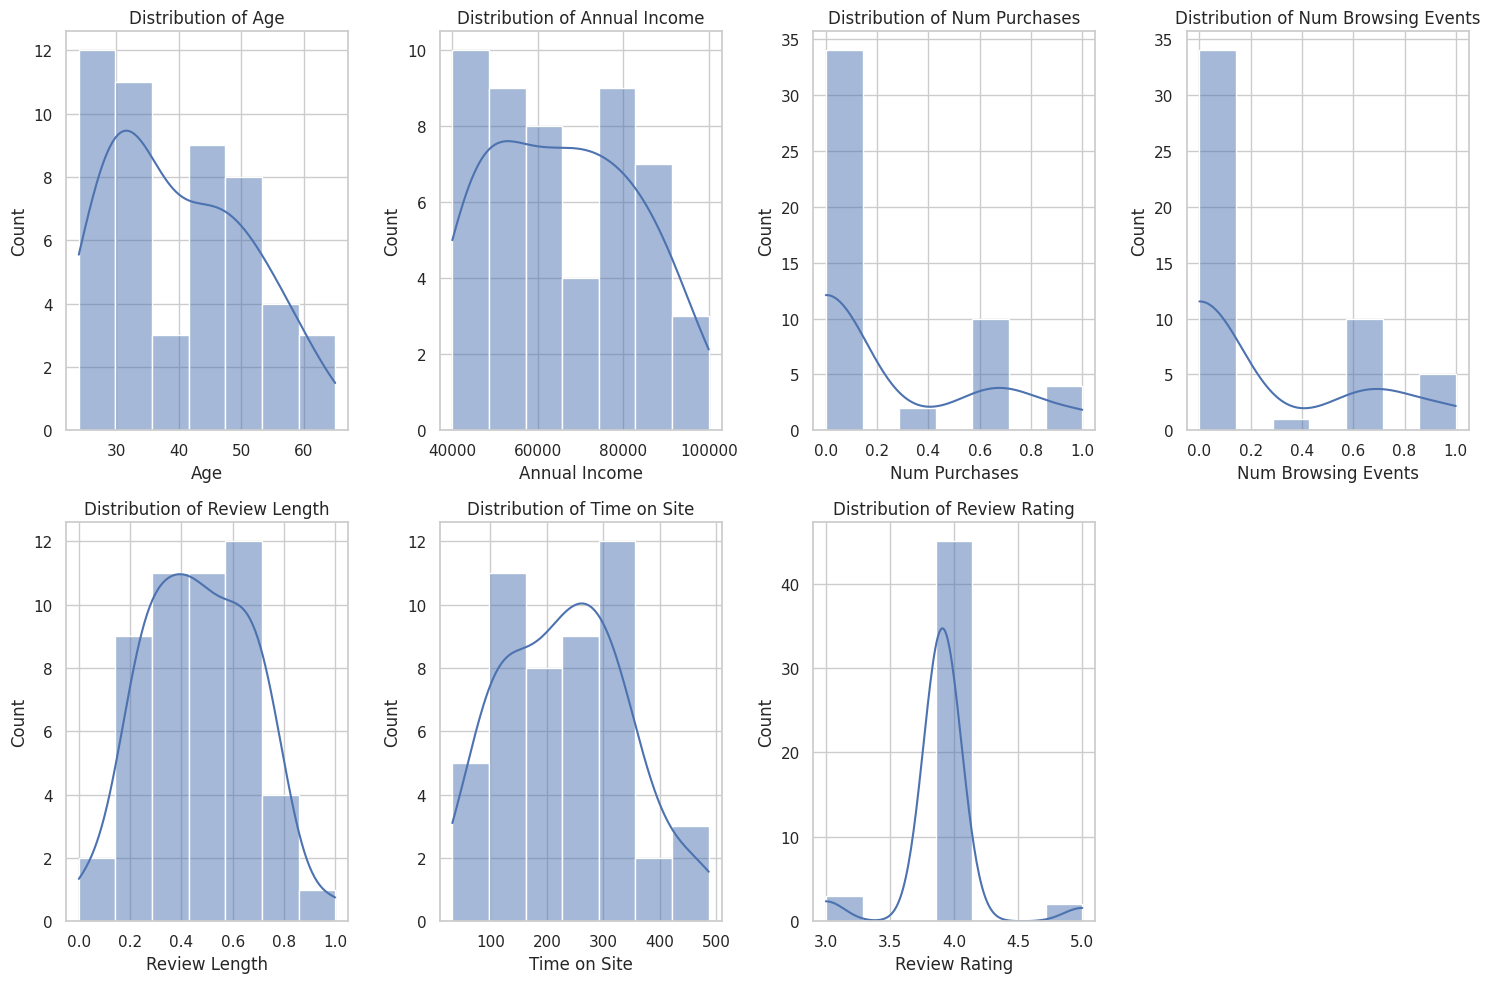

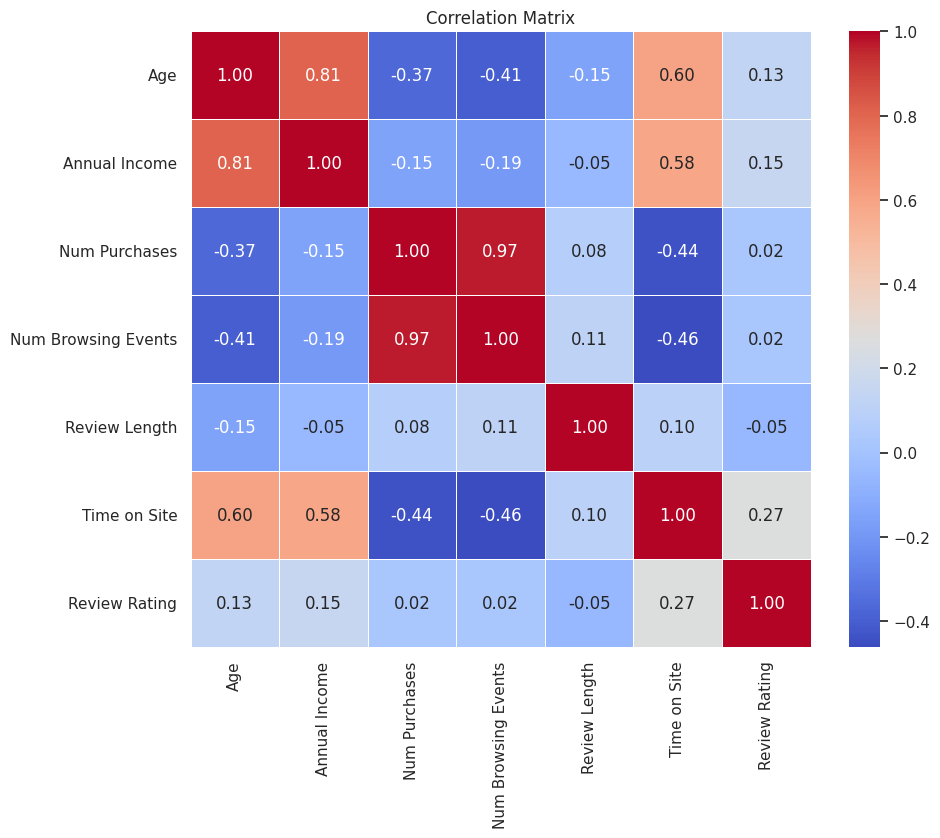

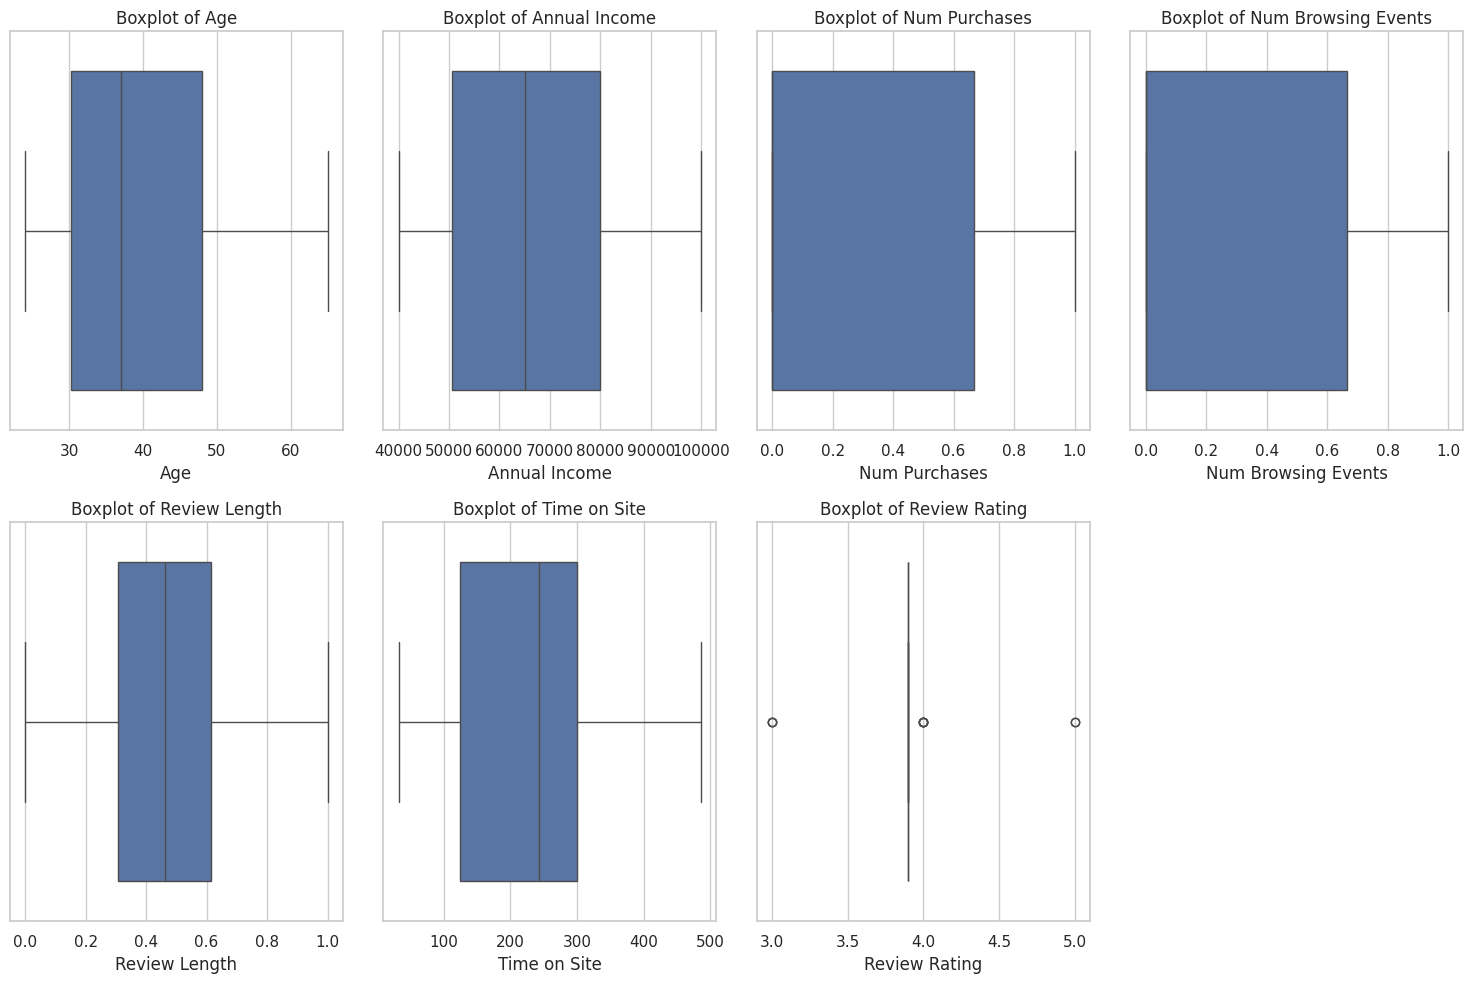

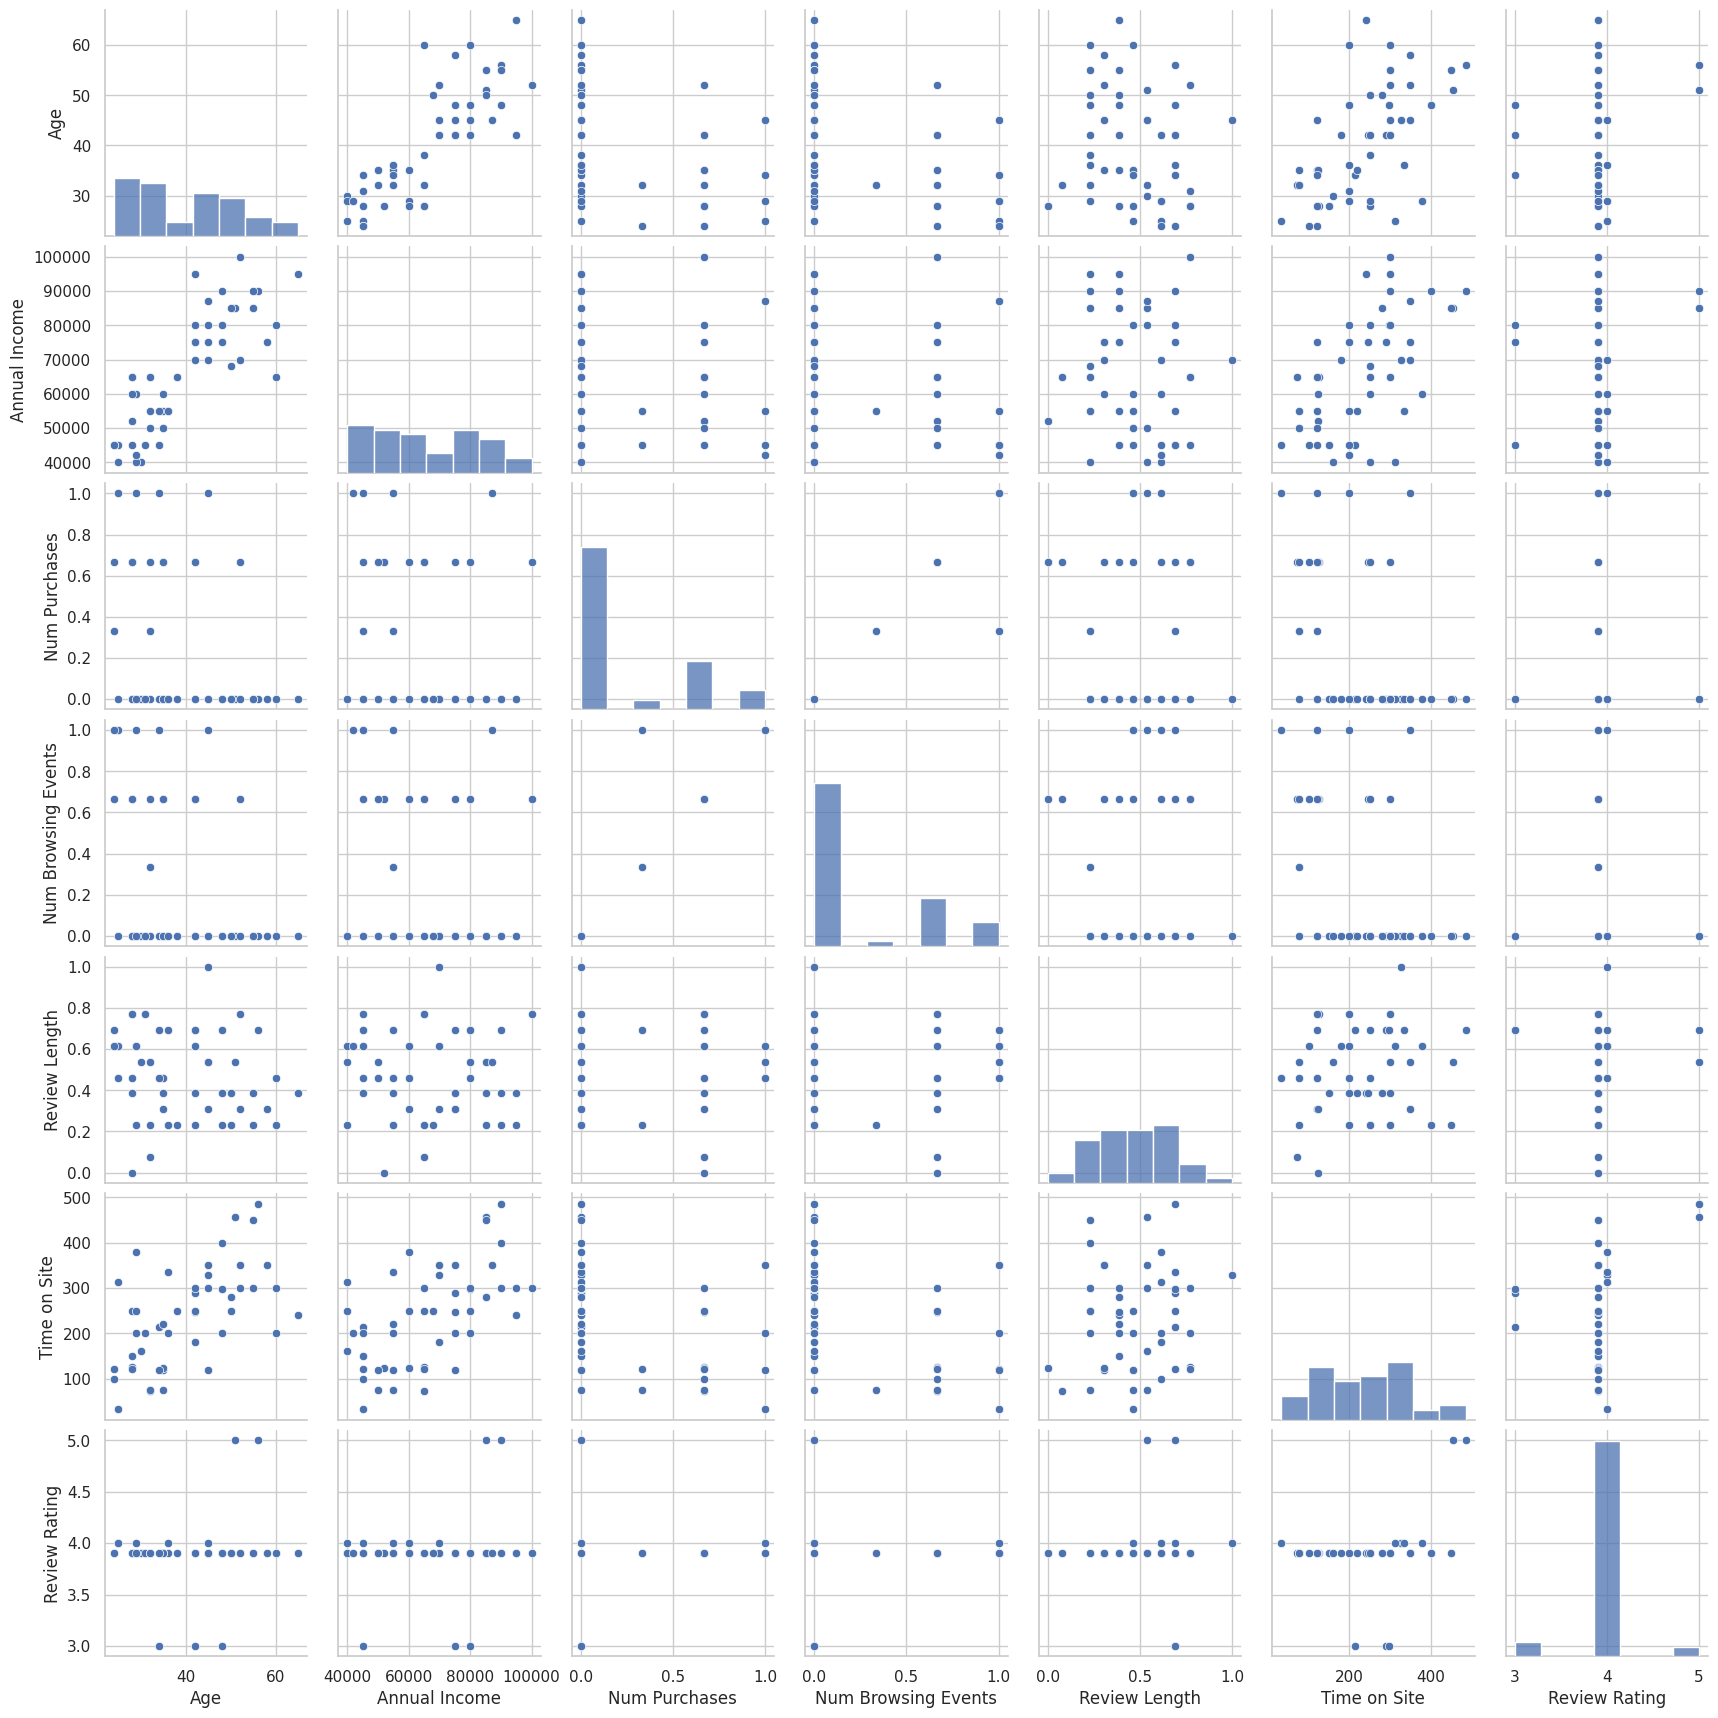

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for better aesthetics
sns.set(style="whitegrid")

# 1. Histograms of Numerical Features
numerical_columns = ['Age', 'Annual Income', 'Num Purchases', 'Num Browsing Events', 'Review Length', 'Time on Site', 'Review Rating']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 4, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# 2. Correlation Matrix (Heatmap)
plt.figure(figsize=(10, 8))
corr = df[numerical_columns].corr()  # Calculate correlation
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# 3. Boxplots for numerical columns to check for outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# 4. Pairplot to visualize relationships between numerical features
sns.pairplot(df[numerical_columns])
plt.show()


In [26]:
# Data Overview
print("First 5 rows of the dataset:")
print(df.head())

# Missing Values
print("\nMissing values per column:")
print(df.isnull().sum())


First 5 rows of the dataset:
   Customer ID  Age  Gender  Annual Income  \
0         1001   25     0.0          45000   
1         1001   28     0.0          52000   
2         1001   28     0.0          65000   
3         1001   45     0.0          70000   
4         1002   34     1.0          45000   

                                    Purchase History  \
0  [{'Date': '2022-03-05', 'Category': 'Clothing'...   
1  [{'Product Category': 'Clothing', 'Purchase Da...   
2  [{'Product Category': 'Electronics', 'Purchase...   
3  ({'Purchase Date': '2022-08-15', 'Product Cate...   
4  ({'Purchase Date': '2022-07-25', 'Product Cate...   

                                    Browsing History  \
0  [{'Timestamp': '2022-03-10T14:30:00Z'}, {'Time...   
1  [{'Product Category': 'Home & Garden', 'Timest...   
2  [{'Product Category': 'Clothing', 'Timestamp':...   
3               {'Timestamp': '2022-09-03 14:30:00'}   
4               {'Timestamp': '2022-08-10 17:15:00'}   

                    

In [27]:
# Impute missing Gender values with the mode (most frequent value)
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)


<ipython-input-27-ea578aaf9bc9>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)


In [28]:
# Summary Statistics for Numerical Features
print(df.describe())


       Customer ID        Age     Gender  Annual Income  Time on Site  \
count    50.000000  50.000000  50.000000      50.000000     50.000000   
mean   1004.880000  39.960000   0.360000   65780.000000    232.597000   
std       3.623281  11.067437   0.484873   17059.667198    109.669736   
min    1001.000000  24.000000   0.000000   40000.000000     32.500000   
25%    1002.000000  30.250000   0.000000   50500.000000    124.100000   
50%    1004.000000  37.000000   0.000000   65000.000000    243.450000   
75%    1007.750000  48.000000   1.000000   80000.000000    300.000000   
max    1013.000000  65.000000   1.000000  100000.000000    486.300000   

       Review Rating  Num Purchases  Num Browsing Events  Review Length  \
count      50.000000      50.000000            50.000000      50.000000   
mean        3.900000       0.226667             0.240000       0.470769   
std         0.316228       0.352767             0.369101       0.210025   
min         3.000000       0.000000       

In [29]:
import pandas as pd
df = pd.read_csv('/content/E-commerce.csv')  # Replace with the correct file path


##ANALYZE THE DATA QUALITY


Missing values in each column:
 Customer ID         0
Age                 0
Gender              0
Location            0
Annual Income       0
Purchase History    0
Browsing History    0
Product Reviews     0
Time on Site        0
dtype: int64


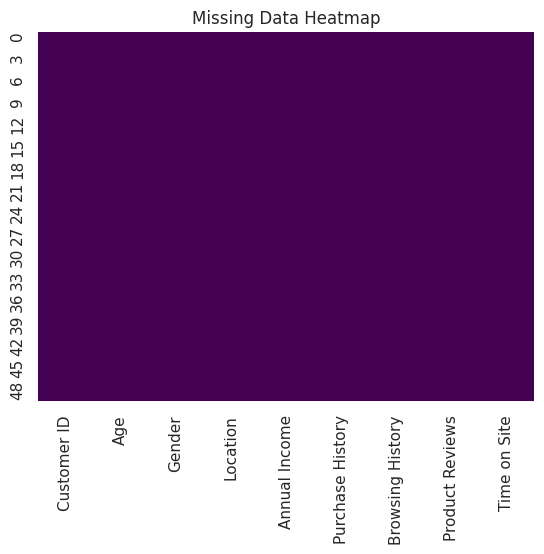

In [30]:
# Check for missing values again
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Optionally, visualize missing data
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()


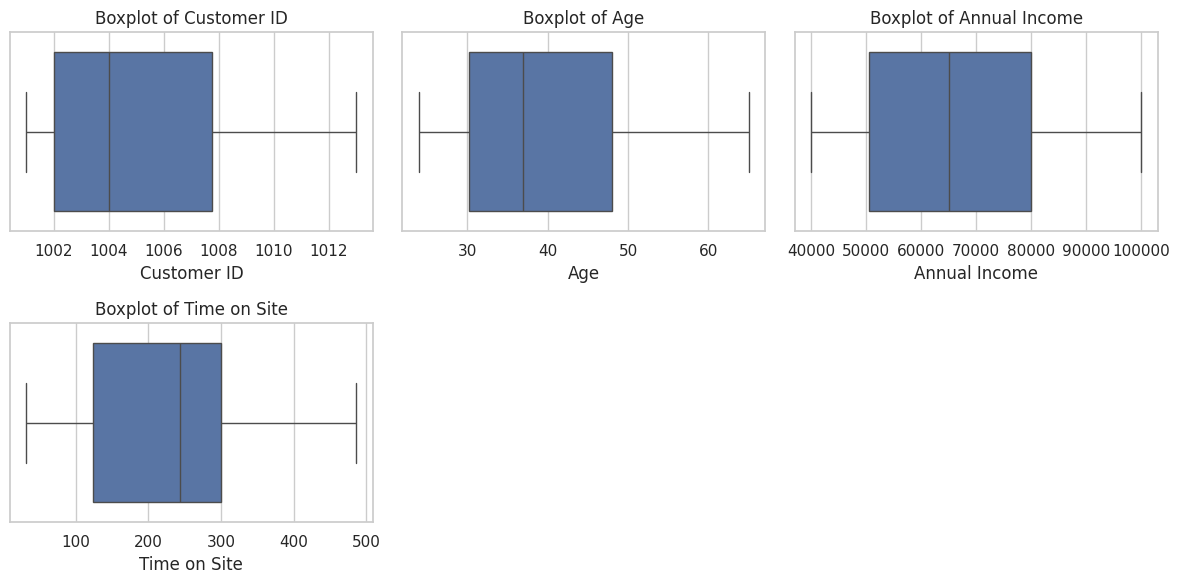

In [31]:
# Boxplot for numeric columns to detect outliers
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12, 6))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


In [32]:
# Check for duplicate rows
duplicate_rows = df[df.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")


Number of duplicate rows: 0


In [33]:
# Check the data types of each column
print(df.dtypes)

# Convert columns to appropriate data types (if needed)
# For example, if 'Gender' should be categorical:
df['Gender'] = df['Gender'].astype('category')


Customer ID           int64
Age                   int64
Gender               object
Location             object
Annual Income         int64
Purchase History     object
Browsing History     object
Product Reviews      object
Time on Site        float64
dtype: object


In [34]:
# Convert 'Gender' and 'Location' columns to category type
df['Gender'] = df['Gender'].astype('category')
df['Location'] = df['Location'].astype('category')



In [35]:
# Check for any incorrect or illogical values
print(df[df['Age'] < 0])  # Negative age values
print(df[df['Annual Income'] < 0])  # Negative income values


Empty DataFrame
Columns: [Customer ID, Age, Gender, Location, Annual Income, Purchase History, Browsing History, Product Reviews, Time on Site]
Index: []
Empty DataFrame
Columns: [Customer ID, Age, Gender, Location, Annual Income, Purchase History, Browsing History, Product Reviews, Time on Site]
Index: []


In [36]:
# Checking value counts for Gender and Location
print(df['Gender'].value_counts())
print(df['Location'].value_counts())


Gender
Female    26
Male      18
Other      6
Name: count, dtype: int64
Location
City D    12
City E     6
City F     5
City G     4
City H     4
City K     3
City J     3
City I     3
City L     3
City B     1
City C     1
City A     1
City M     1
City N     1
City O     1
City P     1
Name: count, dtype: int64


In [37]:
df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1, 'Other': 2})


In [38]:
df = pd.get_dummies(df, columns=['Location'])


In [39]:
location_threshold = 5  # Cities with fewer than 5 occurrences will be grouped into 'Other'
location_counts = df['Location'].value_counts()
df['Location'] = df['Location'].apply(lambda x: x if location_counts[x] >= location_threshold else 'Other')


KeyError: 'Location'

In [41]:
print(df.columns)


Index(['Customer ID', 'Age', 'Gender', 'Annual Income', 'Purchase History',
       'Browsing History', 'Product Reviews', 'Time on Site',
       'Location_City A', 'Location_City B', 'Location_City C',
       'Location_City D', 'Location_City E', 'Location_City F',
       'Location_City G', 'Location_City H', 'Location_City I',
       'Location_City J', 'Location_City K', 'Location_City L',
       'Location_City M', 'Location_City N', 'Location_City O',
       'Location_City P'],
      dtype='object')


In [42]:
location_columns = [col for col in df.columns if 'Location_City' in col]
city_distribution = df[location_columns].sum(axis=0)
print(city_distribution)


Location_City A     1
Location_City B     1
Location_City C     1
Location_City D    12
Location_City E     6
Location_City F     5
Location_City G     4
Location_City H     4
Location_City I     3
Location_City J     3
Location_City K     3
Location_City L     3
Location_City M     1
Location_City N     1
Location_City O     1
Location_City P     1
dtype: int64


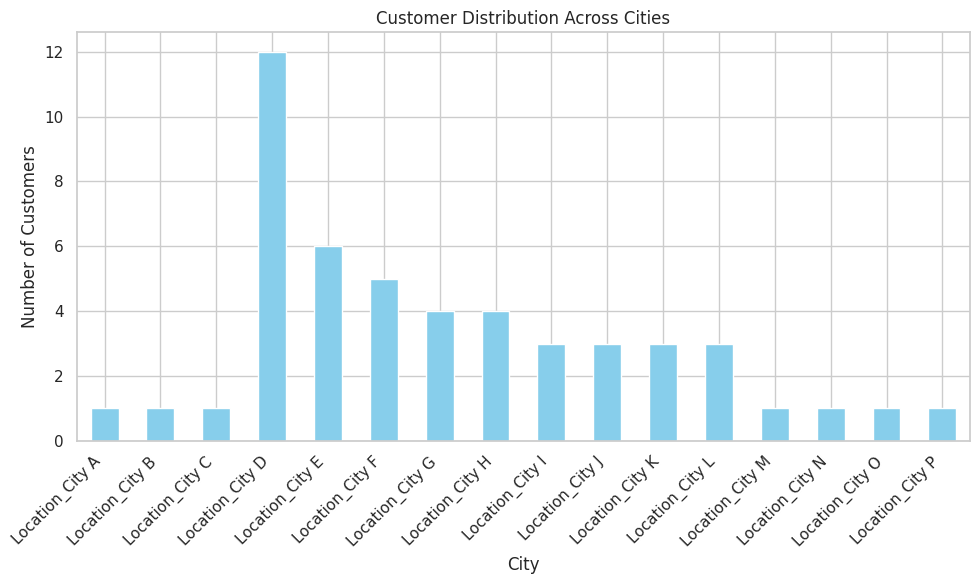

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Redefining the dataset for visualization
data = {
    'Location_City A': [1],
    'Location_City B': [1],
    'Location_City C': [1],
    'Location_City D': [12],
    'Location_City E': [6],
    'Location_City F': [5],
    'Location_City G': [4],
    'Location_City H': [4],
    'Location_City I': [3],
    'Location_City J': [3],
    'Location_City K': [3],
    'Location_City L': [3],
    'Location_City M': [1],
    'Location_City N': [1],
    'Location_City O': [1],
    'Location_City P': [1]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# City counts for visualization
city_counts = df.sum()

# Plot the distribution
plt.figure(figsize=(10, 6))
city_counts.plot(kind='bar', color='skyblue')
plt.title('Customer Distribution Across Cities')
plt.xlabel('City')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


##CLEANING OF DATA


In [44]:
import pandas as pd

df = pd.read_csv('E-commerce.csv')  # Replace with your file path if needed
df.head()


,Customer ID,Age,Gender,Location,Annual Income,Purchase History,Browsing History,Product Reviews,Time on Site
0,1001,25,Female,City D,45000,"[{""Date"": ""2022-03-05"", ""Category"": ""Clothing""...","[{""Timestamp"": ""2022-03-10T14:30:00Z""}, {""Time...","Great pair of jeans, very comfortable. Rating:...",32.50
1,1001,28,Female,City D,52000,"[{""Product Category"": ""Clothing"", ""Purchase Da...","[{""Product Category"": ""Home & Garden"", ""Timest...",Great customer service!,123.45
2,1001,28,Female,City D,65000,"[{""Product Category"": ""Electronics"", ""Purchase...","[{""Product Category"": ""Clothing"", ""Timestamp"":...",Great electronics. The sound quality is excell...,125.60
3,1001,45,Female,City D,70000,"{'Purchase Date': '2022-08-15', 'Product Categ...",{'Timestamp': '2022-09-03 14:30:00'},"{""Product 1"": {""Rating"": 4, ""Review"": ""Great e...",327.60
4,1002,34,Male,City E,45000,"{'Purchase Date': '2022-07-25', 'Product Categ...",{'Timestamp': '2022-08-10 17:15:00'},"{""Product 1"": {""Rating"": 3, ""Review"": ""Good pr...",214.90


In [45]:
import ast
import json

def safe_parse(val):
    try:
        if isinstance(val, str):
            return ast.literal_eval(val)
        return val
    except:
        return None

for col in ['Purchase History', 'Browsing History', 'Product Reviews']:
    df[col] = df[col].apply(safe_parse)

df[['Purchase History', 'Browsing History', 'Product Reviews']].head()


,Purchase History,Browsing History,Product Reviews
0,"[{'Date': '2022-03-05', 'Category': 'Clothing'...","[{'Timestamp': '2022-03-10T14:30:00Z'}, {'Time...",None
1,"[{'Product Category': 'Clothing', 'Purchase Da...","[{'Product Category': 'Home & Garden', 'Timest...",None
2,"[{'Product Category': 'Electronics', 'Purchase...","[{'Product Category': 'Clothing', 'Timestamp':...",None
3,"({'Purchase Date': '2022-08-15', 'Product Cate...",{'Timestamp': '2022-09-03 14:30:00'},"{'Product 1': {'Rating': 4, 'Review': 'Great e..."
4,"({'Purchase Date': '2022-07-25', 'Product Cate...",{'Timestamp': '2022-08-10 17:15:00'},"{'Product 1': {'Rating': 3, 'Review': 'Good pr..."


In [46]:
def clean_to_list(val):
    if isinstance(val, tuple):
        val = val[0]  # get dict from tuple
    if isinstance(val, dict):
        return [val]
    if isinstance(val, list):
        return val
    return None

df['Purchase History'] = df['Purchase History'].apply(clean_to_list)
df['Browsing History'] = df['Browsing History'].apply(clean_to_list)


In [48]:
def extract_review_info(val):
    if isinstance(val, dict):
        for product in val.values():
            return product.get('Rating', None), product.get('Review', None)
    return None, None

df[['Review Rating', 'Review Text']] = df['Product Reviews'].apply(
    lambda x: pd.Series(extract_review_info(x))
)


AttributeError: 'str' object has no attribute 'get'

In [50]:
import ast

def safe_parse(val):
    try:
        if isinstance(val, str):
            return ast.literal_eval(val)
        return val
    except:
        return None

df['Product Reviews'] = df['Product Reviews'].apply(safe_parse)


In [51]:
def extract_review_info(val):
    if isinstance(val, dict):
        for product in val.values():
            if isinstance(product, dict):
                return product.get('Rating', None), product.get('Review', None)
    return None, None

df[['Review Rating', 'Review Text']] = df['Product Reviews'].apply(
    lambda x: pd.Series(extract_review_info(x))
)


In [52]:
df['Review Rating'] = df['Review Rating'].fillna(0)
df['Review Text'] = df['Review Text'].fillna("No Review")


In [53]:
import ast

def parse_and_wrap(val):
    try:
        if isinstance(val, tuple):  # If it's a tuple with one dict inside
            val = val[0]
        if isinstance(val, str):
            val = ast.literal_eval(val)
        if isinstance(val, dict):  # Wrap dict in list
            return [val]
        elif isinstance(val, list):
            return val
    except:
        return None
    return None


In [54]:
df['Purchase History'] = df['Purchase History'].apply(parse_and_wrap)
df['Browsing History'] = df['Browsing History'].apply(parse_and_wrap)


In [55]:
print(df['Purchase History'].apply(type).value_counts())
print(df['Browsing History'].apply(type).value_counts())


Purchase History
<class 'list'>    50
Name: count, dtype: int64
Browsing History
<class 'list'>    50
Name: count, dtype: int64


In [56]:
# Look at one clean row
import json
print(json.dumps(df['Purchase History'][0], indent=2))
print(json.dumps(df['Browsing History'][0], indent=2))


[
  {
    "Date": "2022-03-05",
    "Category": "Clothing",
    "Price": 34.99
  },
  {
    "Date": "2022-02-12",
    "Category": "Electronics",
    "Price": 129.99
  },
  {
    "Date": "2022-01-20",
    "Category": "Home & Garden",
    "Price": 29.99
  }
]
[
  {
    "Timestamp": "2022-03-10T14:30:00Z"
  },
  {
    "Timestamp": "2022-03-11T09:45:00Z"
  },
  {
    "Timestamp": "2022-03-12T16:20:00Z"
  }
]


##SENTIMENT ANALYSIS


In [57]:
!pip install vaderSentiment



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.7 MB/s eta 0:00:00


In [58]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()


In [59]:
def get_sentiment_score(text):
    if text and isinstance(text, str):
        return analyzer.polarity_scores(text)['compound']
    return 0.0  # neutral for empty/missing reviews

df['Sentiment Score'] = df['Review Text'].apply(get_sentiment_score)


LABEL SENTIMENT CATEGORY

In [60]:
def label_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment Label'] = df['Sentiment Score'].apply(label_sentiment)


RESULT

In [61]:
df[['Review Text', 'Sentiment Score', 'Sentiment Label']].head(10)


,Review Text,Sentiment Score,Sentiment Label
0,No Review,-0.2960,Negative
1,No Review,-0.2960,Negative
2,No Review,-0.2960,Negative
3,Great experience buying this product. Fast del...,0.8316,Positive
4,"Good product, but could have been better.",0.7003,Positive
5,"Awesome product, highly recommend it to everyone.",0.7841,Positive
6,"Great product, will definitely buy again.",0.7783,Positive
7,"Good product, but not worth the price.",-0.0127,Neutral
8,"Outstanding product, exceeded my expectations.",0.6124,Positive
9,"Good product, but could have been better.",0.7003,Positive


SENTIMENT DISTRIBUTION


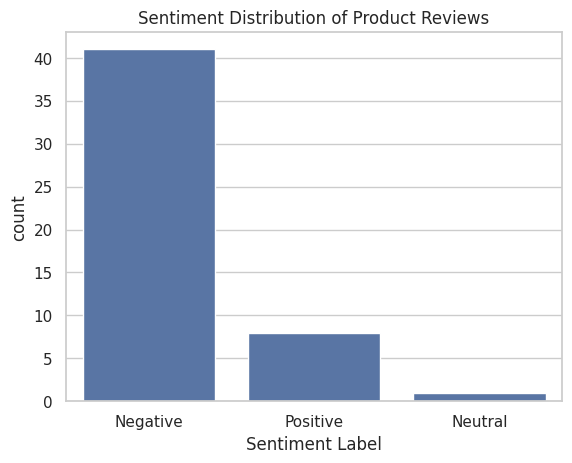

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='Sentiment Label')
plt.title("Sentiment Distribution of Product Reviews")
plt.show()


In [63]:
df.to_csv('cleaned_ecommerce_data.csv', index=False)


In [64]:
from google.colab import files
files.download('cleaned_ecommerce_data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [65]:
import pandas as pd
import ast

# Load your cleaned dataset (update path if needed)
df = pd.read_csv('cleaned_ecommerce_data.csv')

# -----------------------
# Step 1: Parse JSON-like strings in 'Purchase History'
# -----------------------

# Function to safely convert stringified lists/dicts into Python objects
def parse_purchase_history(history_str):
    try:
        return ast.literal_eval(history_str)
    except (ValueError, SyntaxError):
        return []

# Apply parsing to the column
df['Parsed Purchase History'] = df['Purchase History'].apply(parse_purchase_history)

# -----------------------
# Step 2: Extract Product Categories from Parsed Purchase History
# -----------------------

def extract_categories(purchases):
    categories = []
    for item in purchases:
        # Handle variation in keys like 'Category' or 'Product Category'
        category = item.get('Category') or item.get('Product Category')
        if category:
            categories.append(category)
    return categories

# Apply extraction
df['Purchased Categories'] = df['Parsed Purchase History'].apply(extract_categories)

# -----------------------
# Optional: Save result for verification
# -----------------------
df.to_csv('step1_parsed_purchase_history.csv', index=False)

# Preview result
print(df[['Customer ID', 'Purchased Categories']].head())


   Customer ID                    Purchased Categories
0         1001  [Clothing, Electronics, Home & Garden]
1         1001                 [Clothing, Electronics]
2         1001            [Electronics, Home & Garden]
3         1001                           [Electronics]
4         1002                              [Clothing]


##TF-IDF-based Product Similarity & Recommendation

In [66]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load your parsed dataset
df = pd.read_csv('step1_parsed_purchase_history.csv')

import ast
df['Parsed Purchase History'] = df['Parsed Purchase History'].apply(ast.literal_eval)

# Step 1: Build a product-level table
product_records = []

for idx, row in df.iterrows():
    customer_id = row['Customer ID']
    purchases = row['Parsed Purchase History']
    review_text = row.get('Review Text', '')
    sentiment = row.get('Sentiment Score', 0)

    for item in purchases:
        category = item.get('Category') or item.get('Product Category', '')
        if category:
            product_records.append({
                'Customer ID': customer_id,
                'Product Category': category,
                'Review Text': review_text,
                'Sentiment Score': sentiment
            })

products_df = pd.DataFrame(product_records)

# Step 2: Build product profile string
def build_profile(row):
    return f"{row['Product Category']} {row['Review Text']} sentiment:{row['Sentiment Score']}"

products_df['Product Profile'] = products_df.apply(build_profile, axis=1)

# Step 3: TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(products_df['Product Profile'])

# Step 4: Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Step 5: Recommend top N similar products
def recommend_products(product_index, top_n=5):
    sim_scores = list(enumerate(cosine_sim[product_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]  # Exclude self
    recommended_indices = [i[0] for i in sim_scores]
    return products_df.iloc[recommended_indices][['Product Category', 'Review Text', 'Sentiment Score']]

# Example: Recommendations similar to product at index 0
recommendations = recommend_products(0, top_n=5)
print(recommendations)


   Product Category Review Text  Sentiment Score
3          Clothing   No Review           -0.296
16         Clothing   No Review           -0.296
19         Clothing   No Review           -0.296
22         Clothing   No Review           -0.296
25         Clothing   No Review           -0.296


In [70]:
import pandas as pd

# Load your dataset
df = pd.read_csv('/content/cleaned_ecommerce_data.csv')

# Filter out 'No Review' or NaN in 'Review Text'
df = df[df['Review Text'].str.lower() != 'no review']
df = df[df['Review Text'].notna()]


In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['Review Text'])

# Optional: View feature names
# print(tfidf.get_feature_names_out())


In [72]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)


In [73]:
# Create a mapping of product indices and titles or IDs
indices = pd.Series(df.index, index=df['Product Category'])

def get_recommendations(product_index, cosine_sim=cosine_sim):
    sim_scores = list(enumerate(cosine_sim[product_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:6]
    product_indices = [i[0] for i in sim_scores]
    return df.iloc[product_indices][['Product Category', 'Review Text', 'Sentiment Score']]


KeyError: 'Product Category'

In [75]:
import pandas as pd

df = pd.read_csv('/content/cleaned_ecommerce_data.csv')
print(df.columns)


Index(['Customer ID', 'Age', 'Gender', 'Location', 'Annual Income',
       'Purchase History', 'Browsing History', 'Product Reviews',
       'Time on Site', 'Review Rating', 'Review Text', 'Sentiment Score',
       'Sentiment Label'],
      dtype='object')


In [77]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Load data
df = pd.read_csv('/content/cleaned_ecommerce_data.csv')

# Optional: clean column names
df.columns = df.columns.str.strip()

# Step 1: Filter out 'No Review' and missing entries
df = df[df['Review Text'].notna()]
df = df[df['Review Text'].str.lower() != 'no review']

# Step 2: Combine 'Product Reviews' and 'Review Text' for better results
df['combined_text'] = df['Product Reviews'] + " " + df['Review Text']

# Step 3: Apply TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['combined_text'])

# Step 4: Compute cosine similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Step 5: Recommendation function
def get_recommendations(index, cosine_sim=cosine_sim, top_n=5):
    sim_scores = list(enumerate(cosine_sim[index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    indices = [i[0] for i in sim_scores]
    return df.iloc[indices][['Product Reviews', 'Review Text', 'Sentiment Score']]

# 🧪 Example usage:
# Get recommendations for the product at index 0
recommended = get_recommendations(0)
print(recommended)


                                      Product Reviews  \
6   {'Product 1': {'Rating': 4, 'Review': 'Great p...   
11  {'Product 1': {'Rating': 4, 'Review': 'Great p...   
4   {'Product 1': {'Rating': 3, 'Review': 'Good pr...   
9   {'Product 1': {'Rating': 4, 'Review': 'Good pr...   
10  {'Product 1': {'Rating': 3, 'Review': 'Good pr...   

                                  Review Text  Sentiment Score  
6   Great product, will definitely buy again.           0.7783  
11  Great product, will definitely buy again.           0.7783  
4   Good product, but could have been better.           0.7003  
9   Good product, but could have been better.           0.7003  
10     Good product, but not what I expected.           0.2382  


In [78]:
import ast

# Parse the 'Product Reviews' column
def extract_product_name(product_review_str):
    try:
        review_dict = ast.literal_eval(product_review_str)
        return list(review_dict.keys())[0]  # e.g., 'Product 1'
    except:
        return "Unknown Product"

df['Product Name'] = df['Product Reviews'].apply(extract_product_name)


In [79]:
df['combined_text'] = df['Product Name'] + " " + df['Review Text']


In [80]:
recommended = get_recommendations(0)
print(recommended[['Product Name', 'Review Text', 'Sentiment Score']])


KeyError: "['Product Name'] not in index"

In [81]:
def get_recommendations(index, cosine_sim=cosine_sim, top_n=5):
    sim_scores = list(enumerate(cosine_sim[index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    indices = [i[0] for i in sim_scores]
    return df.iloc[indices][['Product Name', 'Review Text', 'Sentiment Score']]


In [82]:
recommended = get_recommendations(0)
print(recommended[['Product Name', 'Review Text', 'Sentiment Score']])


   Product Name                                Review Text  Sentiment Score
6     Product 1  Great product, will definitely buy again.           0.7783
11    Product 1  Great product, will definitely buy again.           0.7783
4     Product 1  Good product, but could have been better.           0.7003
9     Product 1  Good product, but could have been better.           0.7003
10    Product 1     Good product, but not what I expected.           0.2382


Similarity Score Column


In [83]:
def get_recommendations(index, cosine_sim=cosine_sim, top_n=5):
    sim_scores = list(enumerate(cosine_sim[index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    indices = [i[0] for i in sim_scores]
    sim_values = [i[1] for i in sim_scores]

    result = df.iloc[indices].copy()
    result['Similarity Score'] = sim_values
    return result[['Product Name', 'Review Text', 'Sentiment Score', 'Similarity Score']]


In [87]:
recommended = get_recommendations(0)
print(recommended)


   Product Name                                Review Text  Sentiment Score  \
6     Product 1  Great product, will definitely buy again.           0.7783   
11    Product 1  Great product, will definitely buy again.           0.7783   
4     Product 1  Good product, but could have been better.           0.7003   
9     Product 1  Good product, but could have been better.           0.7003   

    Similarity Score  
6           0.217382  
11          0.217382  
4           0.115539  
9           0.115539  


Filter by Sentiment (Positive Reviews Only)


In [85]:
def get_recommendations(index, cosine_sim=cosine_sim, top_n=5, sentiment_threshold=0.5):
    sim_scores = list(enumerate(cosine_sim[index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    indices = [i[0] for i in sim_scores]
    sim_values = [i[1] for i in sim_scores]

    result = df.iloc[indices].copy()
    result['Similarity Score'] = sim_values

    # Filter by sentiment score
    result = result[result['Sentiment Score'] > sentiment_threshold]

    return result[['Product Name', 'Review Text', 'Sentiment Score', 'Similarity Score']]


In [86]:
recommended = get_recommendations(0)
print(recommended)


   Product Name                                Review Text  Sentiment Score  \
6     Product 1  Great product, will definitely buy again.           0.7783   
11    Product 1  Great product, will definitely buy again.           0.7783   
4     Product 1  Good product, but could have been better.           0.7003   
9     Product 1  Good product, but could have been better.           0.7003   

    Similarity Score  
6           0.217382  
11          0.217382  
4           0.115539  
9           0.115539  


Visualize Sentiments of Recommended Products


In [88]:
import matplotlib.pyplot as plt

def plot_sentiment_scores(recommendations):
    recommendations = recommendations.sort_values(by='Sentiment Score', ascending=False)
    plt.barh(recommendations['Product Name'], recommendations['Sentiment Score'], color='skyblue')
    plt.xlabel('Sentiment Score')
    plt.title('Recommended Product Sentiments')
    plt.gca().invert_yaxis()
    plt.show()


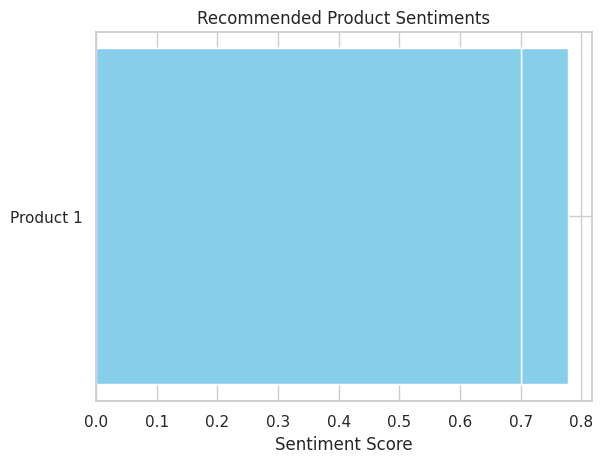

In [89]:
recommended = get_recommendations(0)
plot_sentiment_scores(recommended)


In [90]:
recommended = get_recommendations(0)

# Export to CSV
recommended.to_csv('recommended_products.csv', index=False)

# Or export to Excel
recommended.to_excel('recommended_products.xlsx', index=False)



In [91]:
from google.colab import files
files.download('recommended_products.csv')
# or
files.download('recommended_products.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>